# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *
from src.multitask_transformer import *

In [4]:
config = mlm_config();

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
data_save_name = 'multi_data_idxenc.pkl'

## MSKLM

In [7]:
data = load_data(numpy_path, data_save_name, bs=1)
vocab = data.vocab
learn = multitask_model_learner(data, config.copy())

## Load existing

In [8]:
saved_models = get_files(numpy_path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('data/numpy/combined_tracks/models/MusicTransformer.pth'),
 PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')]

In [9]:
load_path = saved_models[1];
learn.load(load_path.stem);
load_path

PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')

### Predictions - Get midi file

In [10]:
data_dir = 'data/midi/examples/'
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:5]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')]

In [11]:
idx = 2
file = midi_files[idx]; file

PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid')

In [12]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

In [13]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = torch.tensor(item.get_pos(), device=x.device)

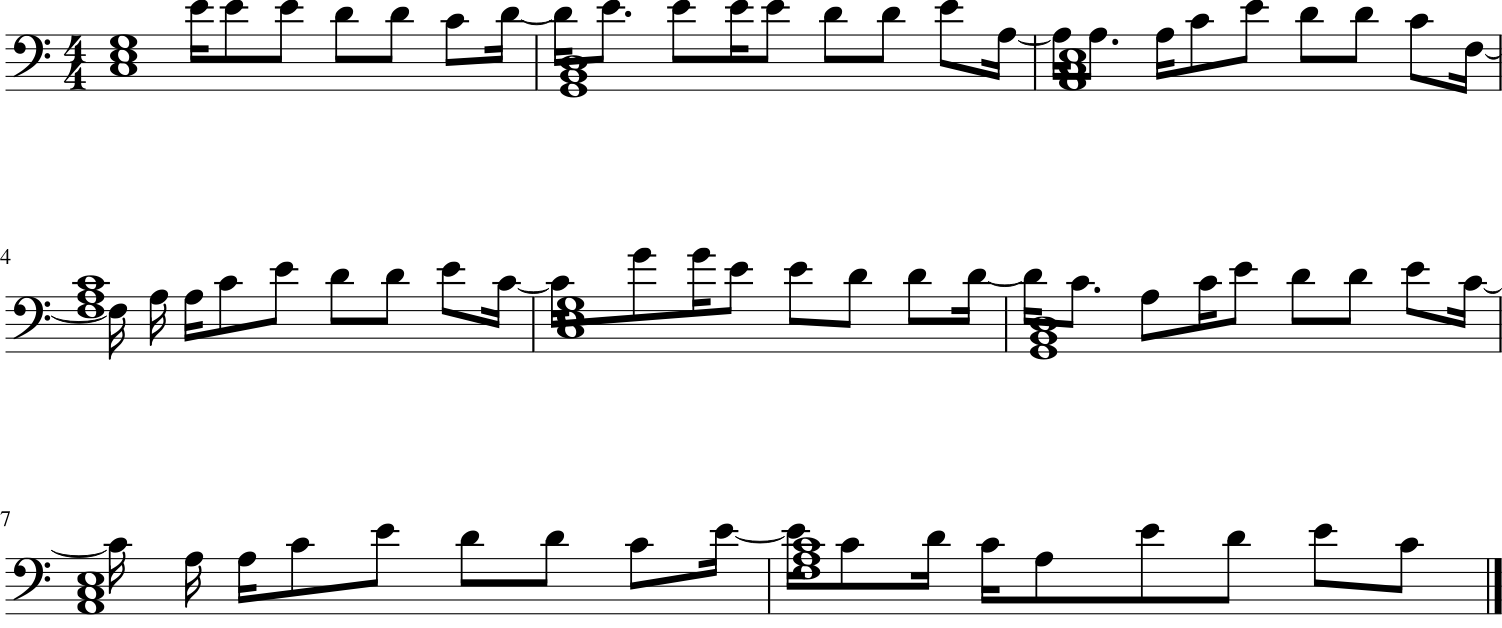

In [15]:
item.show_score()

In [16]:
item.show_midi()

## Predict Mask

#### Regenerate durations

In [17]:
# duration mask
x_dur = mask_input(x, mask_range=vocab.dur_range, replacement_idx=vocab.mask_idx)
pred = learn.predict_mask(x_dur, x_pos, 
                          temperatures=(0.8,0.8), top_k=40, top_p=0.6)

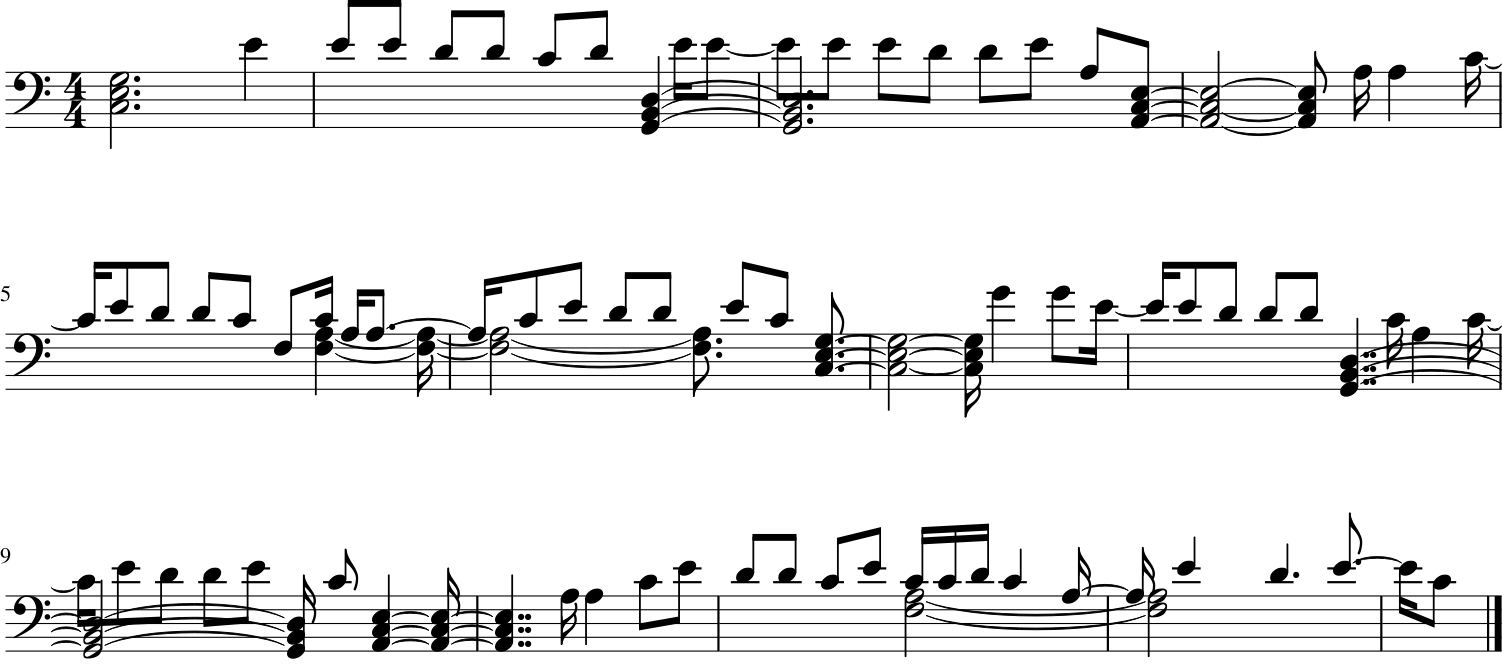

In [18]:
dur_item = vocab.musicify(pred)
dur_item.show_score()

In [19]:
dur_item.show_midi()

#### Regenerate Notes

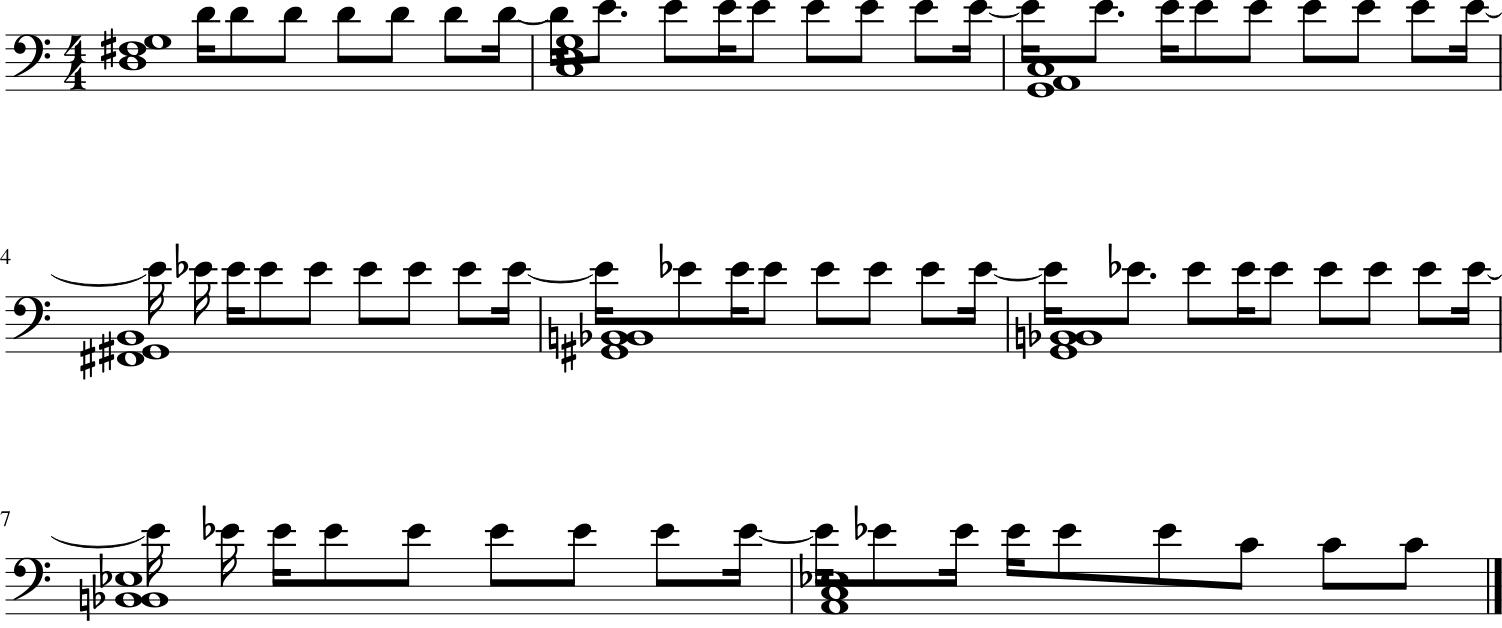

In [20]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
x_note = mask_input(x, mask_range=vocab.note_range, replacement_idx=vocab.mask_idx)
pred_note = learn.predict_mask(x_note)

note_item = vocab.musicify(pred_note)
note_item.show_score()

In [ ]:
# vocab.textify(pred_note)

In [21]:
note_item.show_midi()

In [23]:
out = mask_predict_from_midi(learn, file, predict_notes=True)

In [24]:
vocab.musicify(out).show_midi()

## Prediction next word

In [25]:
seed_len = 4 # 4 beats = 1 bar
seed = item.trim_to_beat(seed_len)

In [26]:
out = learn.predict_nw(seed.to_tensor(), n_words=200)

Predicted BOS token. Returning prediction...


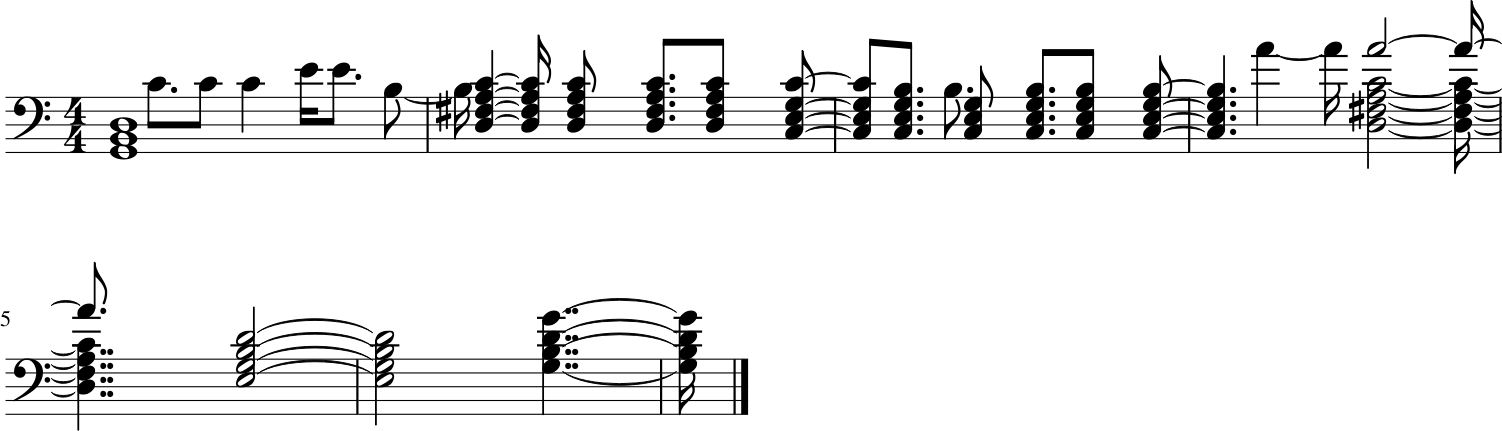

In [27]:
stream = vocab.musicify(out)
stream.show_score()

In [28]:
stream.show_midi()

Convenience function

In [29]:
out = nw_predict_from_midi(learn, file, seed_len=4, top_k=30, top_p=0.5)

In [30]:
# stream = idxenc2stream(out)
# stream.show()

# stream.show('midi')

TypeError: idxenc2stream() missing 1 required positional argument: 'vocab'

## Predict Seq2Seq

In [35]:
melody, chords = midi_extract_melody_chords(file, vocab)

## Predict melody

In [40]:
partial_melody = trim_tfm(melody, vocab, to_beat=3)

In [41]:
idxenc2stream(melody_cut).show()

TypeError: idxenc2stream() missing 1 required positional argument: 'vocab'

In [ ]:
xb_msk = torch.tensor(chords).cuda()
xb_lm = torch.tensor(melody_cut).cuda()

In [ ]:
xb_msk.shape, xb_lm.shape

In [ ]:
out = learn.predict_s2s(xb_msk, xb_lm)

In [ ]:
idxenc2stream(out).show()

In [ ]:
chordarr_comb = s2s_combine2chordarr(out, chords)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [ ]:
comb_stream.show('midi')

## Predict chords

In [ ]:
chord_cut = seed_tfm(chords, seed_len=3)

In [ ]:
idxenc2stream(chord_cut).show()

In [31]:
xb_msk = torch.tensor(melody).cuda()
xb_lm = torch.tensor(chord_cut).cuda()

NameError: name 'melody' is not defined

In [32]:
xb_msk.shape, xb_lm.shape

NameError: name 'xb_msk' is not defined

In [33]:
out = learn.predict_s2s(xb_msk, xb_lm)

NameError: name 'xb_msk' is not defined

In [34]:
idxenc2stream(out).show()

TypeError: idxenc2stream() missing 1 required positional argument: 'vocab'

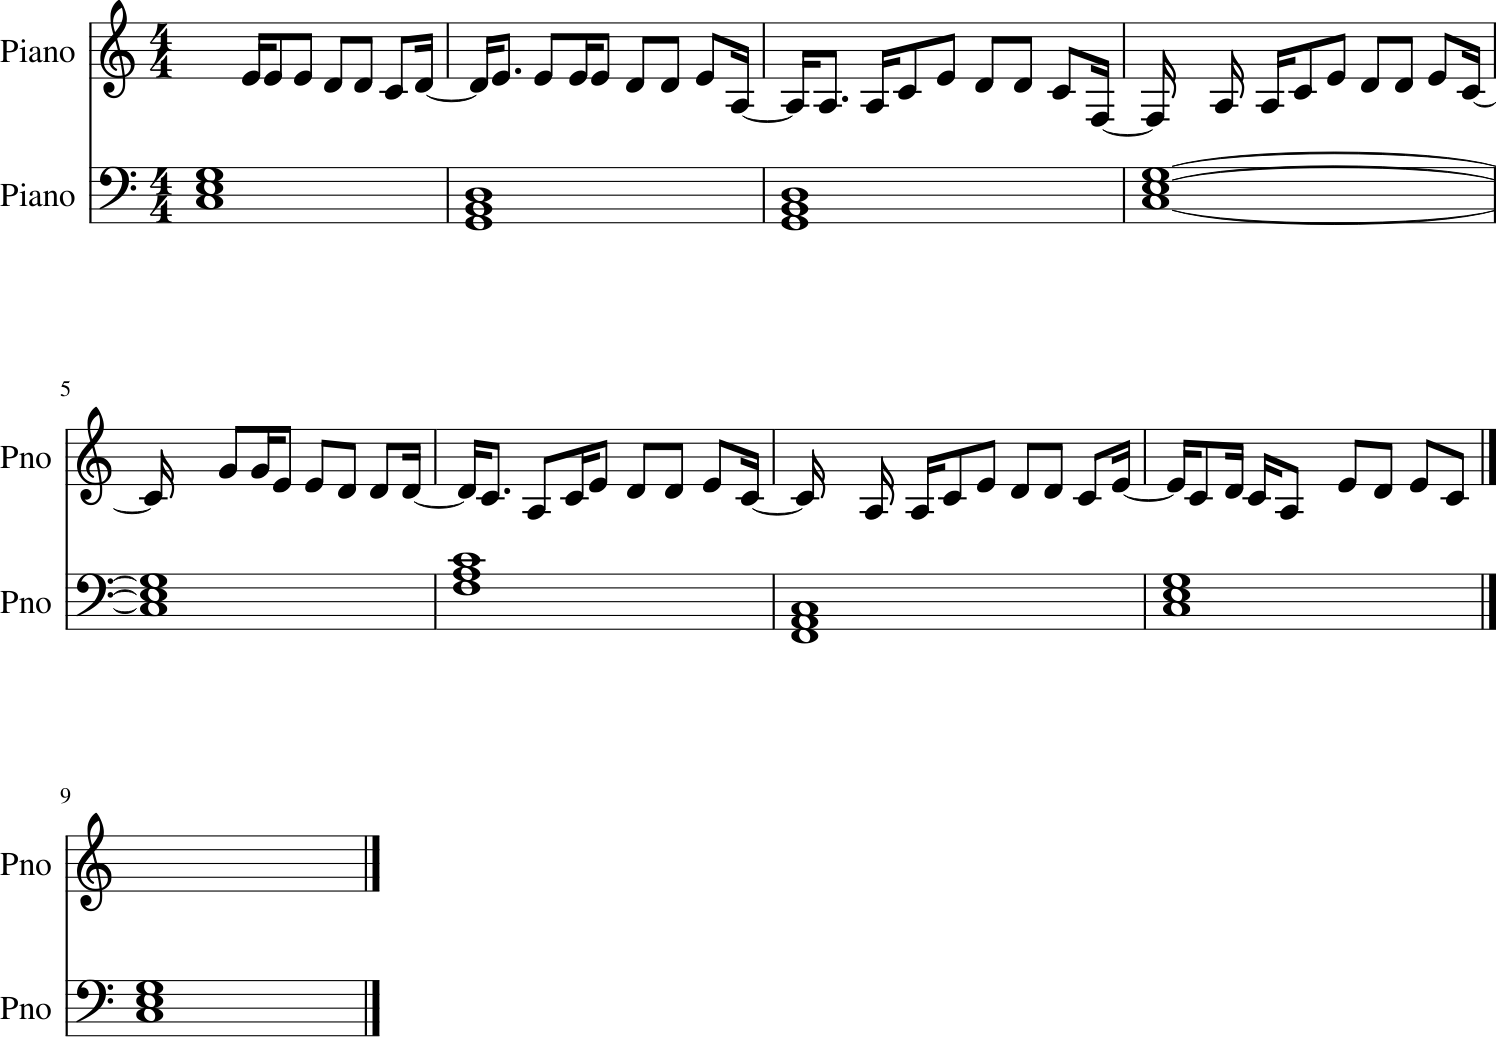

In [54]:
chordarr_comb = s2s_combine2chordarr(melody, out)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [55]:
comb_stream.show('midi')

Convenience Function

In [56]:
out = s2s_predict_from_midi(learn, file, seed_len=10)

Predicted past counter-part length. Returning early


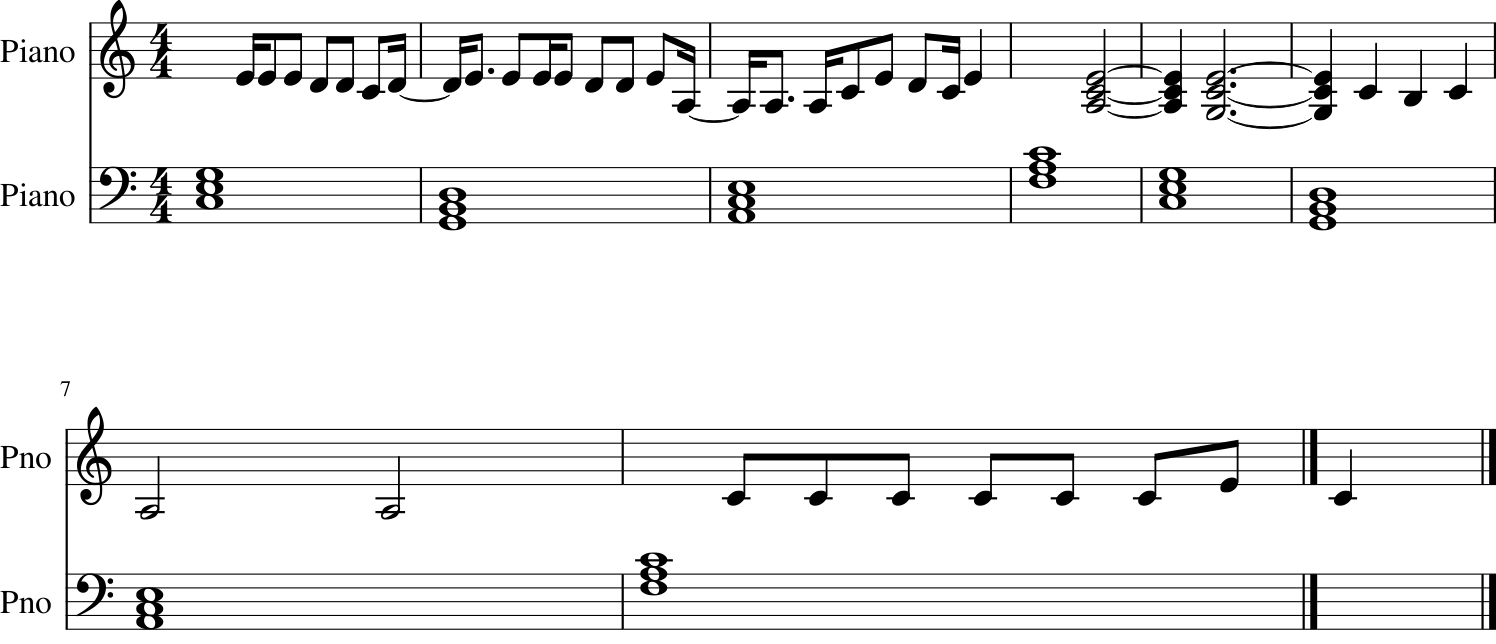

In [57]:
comb_stream = chordarr2stream(out, bpm=108)
comb_stream.show()